In [ ]:
from pathlib import Path

import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from dynamical_systems.analysis import lyapunov_gr
from dynamical_systems.continuous import Lorenz96, solve_ode
from dynamics_discovery.data.utils import generate_ode_dataset
from matplotlib_utils.plots import plot_line_and_band


jax.config.update("jax_enable_x64", True)
plt.style.use("matplotlib_utils.styles.dash_gridded")

datadir = Path("../../data")

DATASET_TYPE = "test"
SEED = 0 if DATASET_TYPE == "train" else 1
NUM_SAMPLES = 5000 if DATASET_TYPE == "train" else 20000

In [2]:
lorenz = Lorenz96()
solve_lorenz_batch = eqx.filter_jit(
    eqx.filter_vmap(
        lambda ts, u0_: solve_ode(
            lorenz, ts, u0_, rtol=1e-8, atol=1e-8, max_steps=None
        ),
        in_axes=(None, 0),
    )
)
u0 = jax.random.normal(jax.random.key(SEED), shape=(NUM_SAMPLES, lorenz.dim))

t = jnp.arange(0, 100, 0.01)
u = solve_lorenz_batch(t, u0)

2025-09-18 18:15:06.282287: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3183] Can't reduce memory use below 14.12GiB (15160940476 bytes) by rematerialization; only reduced to 26.82GiB (28800960128 bytes), down from 26.82GiB (28800960136 bytes) originally


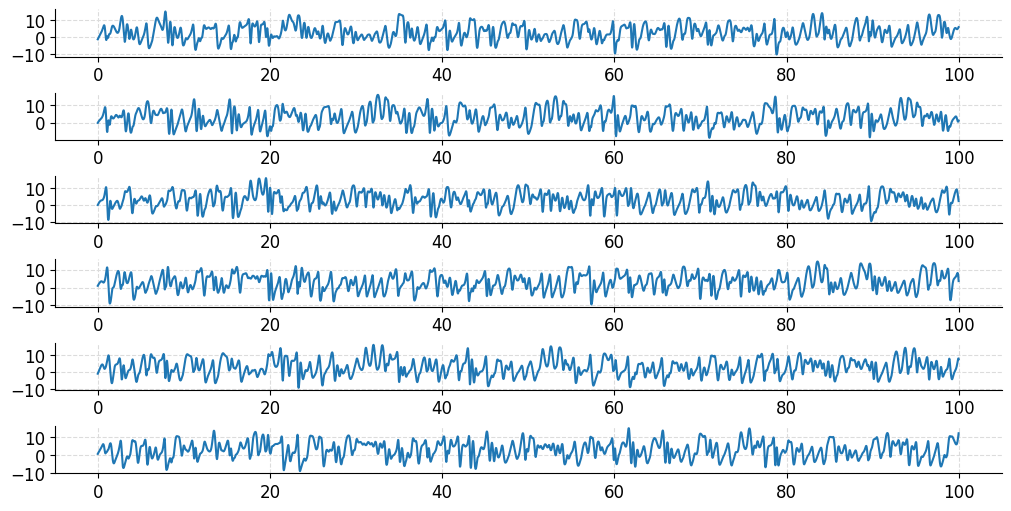

In [3]:
fig, axes = plt.subplots(lorenz.dim, 1, figsize=(10, 5))
for i, ax in enumerate(axes):
    ax.plot(t, u[0, :, i])

In [4]:
t_burnin = 60

u0_init = jax.random.normal(jax.random.key(SEED), shape=(NUM_SAMPLES, lorenz.dim))
u0 = solve_lorenz_batch(jnp.asarray([0, t_burnin]), u0_init)[:, -1]

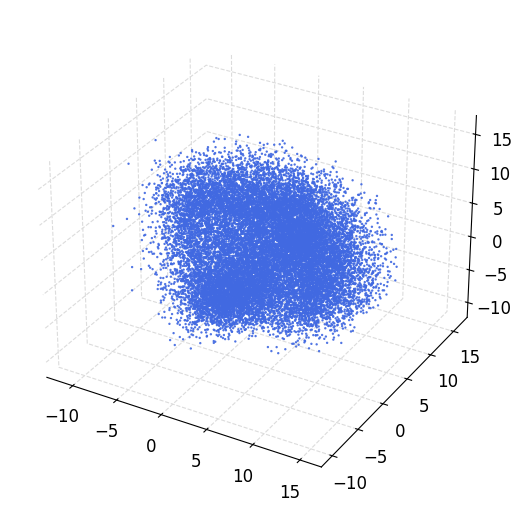

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), subplot_kw={"projection": "3d"})
ax.scatter(*u0[:, :3].T, s=0.5, color="royalblue", alpha=0.9)

In [6]:
from ott.utils import batched_vmap


t_lya = jnp.arange(0.0, 100.0, 0.02)
lyas = batched_vmap(
    lambda u0_: lyapunov_gr(lorenz, u0_, t_lya, rtol=1e-8, atol=1e-8)[0],
    batch_size=5000,
)(u0)[1:]

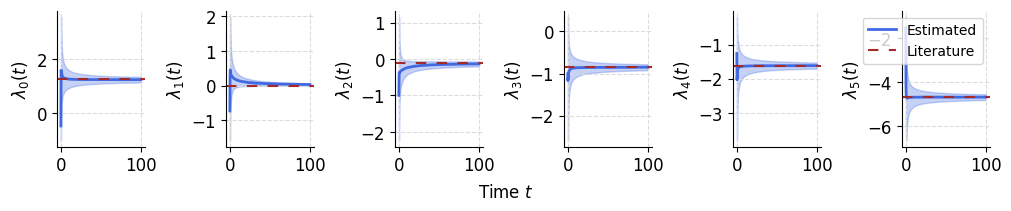

In [ ]:
lyas_mean, lyas_std = jnp.mean(lyas, axis=0), jnp.std(lyas, axis=0)

fig, axes = plt.subplots(1, lorenz.dim, figsize=(10, 2), sharex=True)

plot_kwargs = {"linewidth": 2.0, "alpha": 1.0}
# ax.set_yscale("symlog", base=10)

# From Parlitz et al.
lya_known = (1.249, 0.0, -0.098, -0.853, -1.629, -4.670)

for i, ax in enumerate(axes.flat):
    plot_line_and_band(
        ax, t_lya, lyas_mean[:, i], lyas_std[:, i], label="Estimated", **plot_kwargs
    )
    ax.axhline(
        y=lya_known[i],
        color="brown",
        linewidth=1.5,
        linestyle="--",
        dashes=(5, 5),
        label="Literature",
    )
    ax.set_ylabel(rf"$\lambda_{i}(t)$")

axes[-1].legend(loc="upper right", fontsize="small")
fig.supxlabel("Time $t$", fontsize="medium")
fig.align_ylabels()

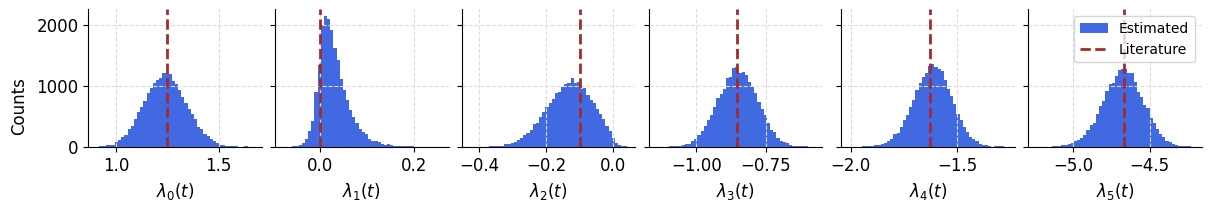

In [8]:
fig, axes = plt.subplots(1, lorenz.dim, figsize=(12, 2), sharey=True)

plot_kwargs = {"linewidth": 2.0, "alpha": 1.0}
# ax.set_yscale("symlog", base=10)


for i, ax in enumerate(axes.flat):
    ax.hist(lyas[:, -1, i], bins=50, color="royalblue", label="Estimated")
    ax.axvline(
        x=lya_known[i],
        color="brown",
        linewidth=2.0,
        linestyle="--",
        label="Literature",
    )
    ax.set_xlabel(rf"$\lambda_{i}(t)$")

axes[-1].legend(loc="upper right", fontsize="small")
fig.supylabel("Counts", fontsize="medium")
fig.align_ylabels()

In [9]:
# ## Save the Lyapunov exponent related results since this is quite expensive to do
jnp.savez(
    datadir / f"lorenz96_lyapunov_{DATASET_TYPE}.npz",
    t=t_lya,
    lyas=lyas,
    lyas_literature=lya_known,
)

In [10]:
lya_max = jnp.max(lyas_mean[-1])
del lyas, u
dataset = generate_ode_dataset(
    lorenz,
    60.0,
    (0.0, 100.0 / lya_max),
    0.01 / lya_max,
    NUM_SAMPLES,
    rtol=1e-8,
    atol=1e-8,
    max_steps=None,
    seed=SEED,
    batch_size=5000,
)

In [11]:
dataset.to_hdf5(datadir / f"lorenz96_{DATASET_TYPE}.hdf5")